# Változó számának csökkentése, változó kiválasztás

## F1/a - normál eloszlású változók generálása

In [1]:
import pandas as pd
import numpy as np

In [2]:
np.random.seed(42)
def get_random_data(n_random_var, n_rows):

    fake_df = pd.DataFrame()
    
    fake_data_dict = {} # to avoid 'DataFrame is highly fragmented' warning coming from appending many columns 1 by 1 

    mu, sigma = 0, 1 # mean and standard deviation
    for i in range(n_random_var):
        fake_data_dict[f'rand_norm_{i}'] = np.random.normal(mu, sigma, n_rows)

    fake_df = pd.DataFrame(fake_data_dict)
    fake_df['target'] = [ind%2 for ind in fake_df.index]
    
    return fake_df

fake_df = get_random_data(n_random_var=1000, n_rows=1797)

## F1/b - Dimenziók átkának demonstrációja

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

train_df, test_df = train_test_split(fake_df, test_size=0.2, random_state=42)

In [4]:
model = LogisticRegression()

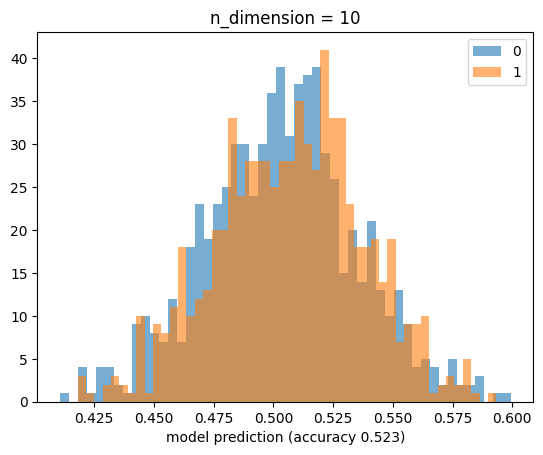

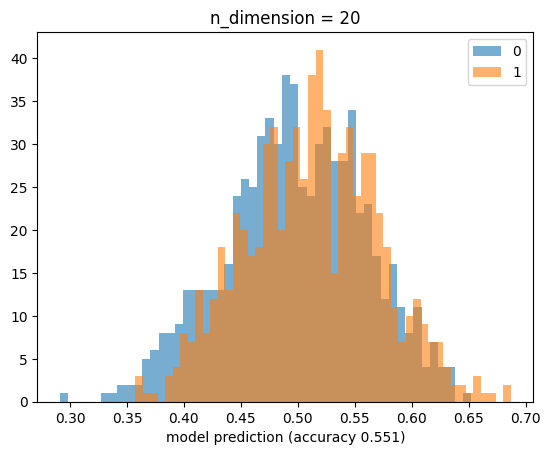

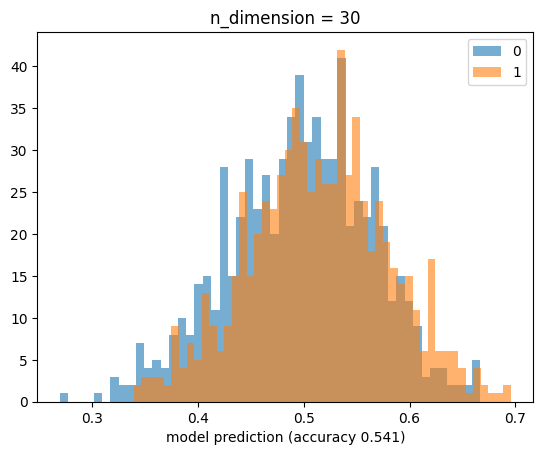

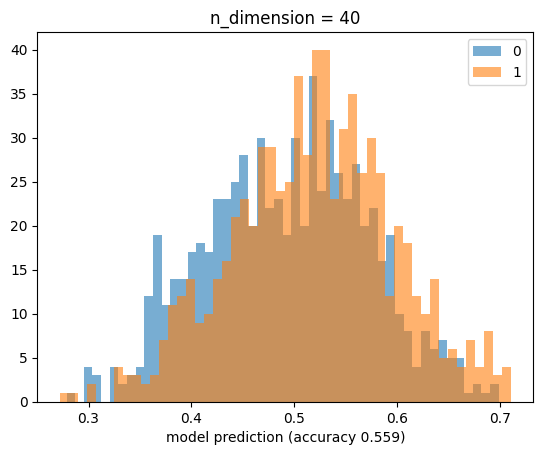

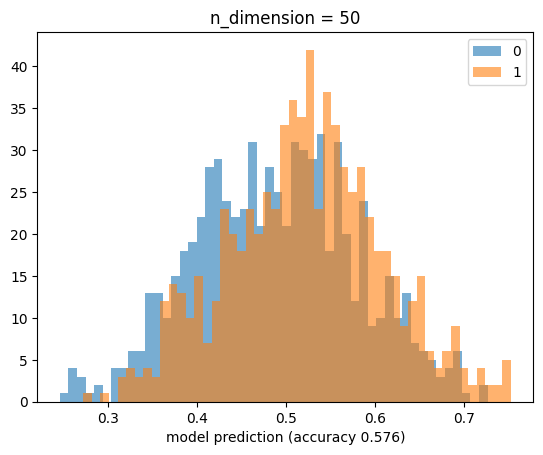

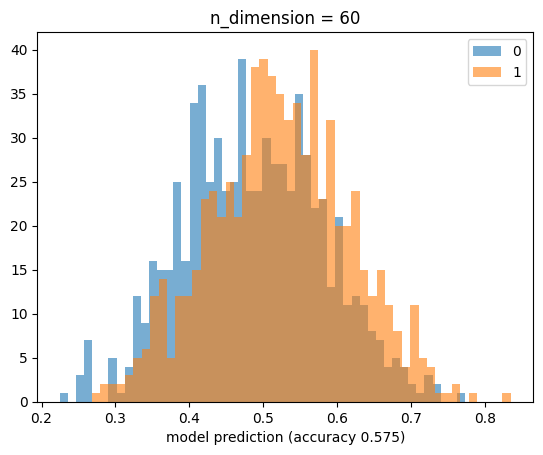

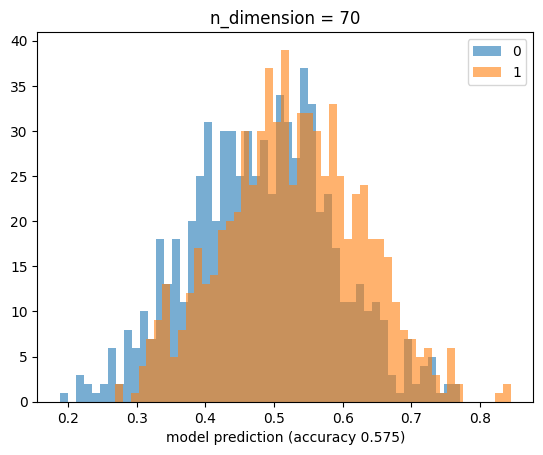

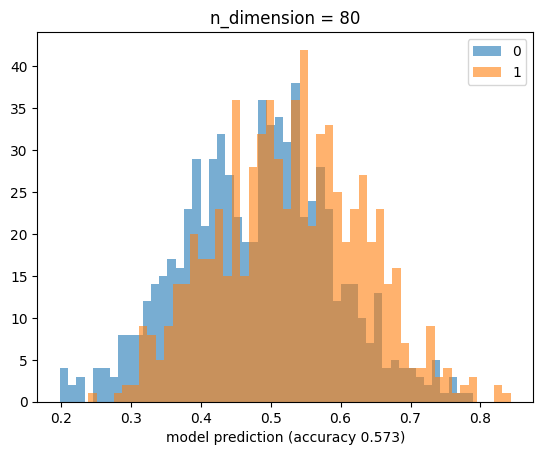

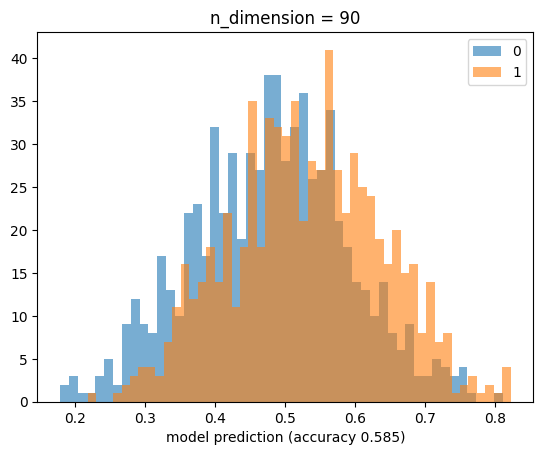

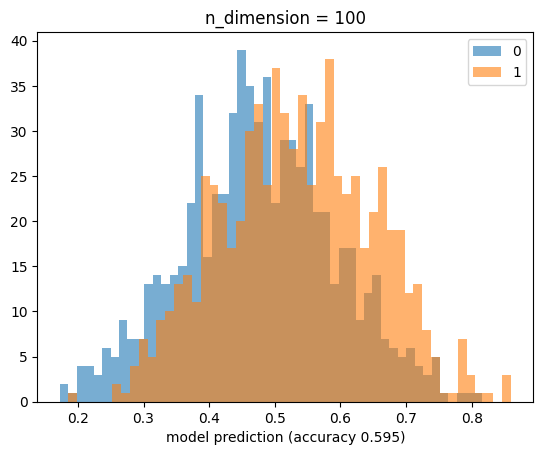

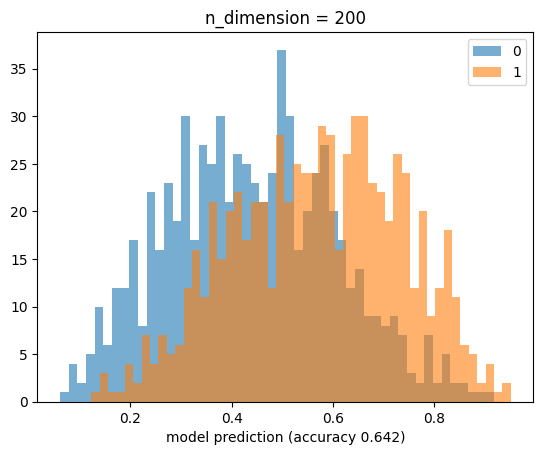

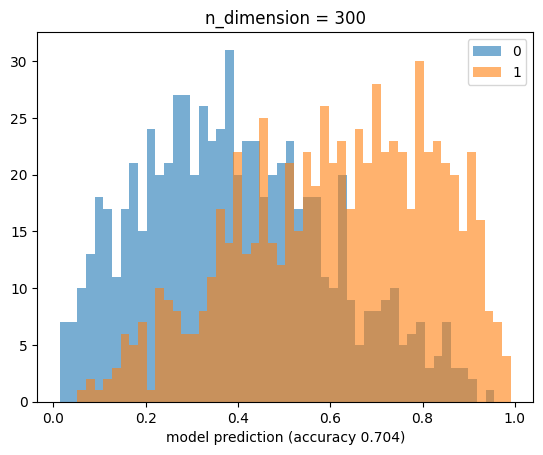

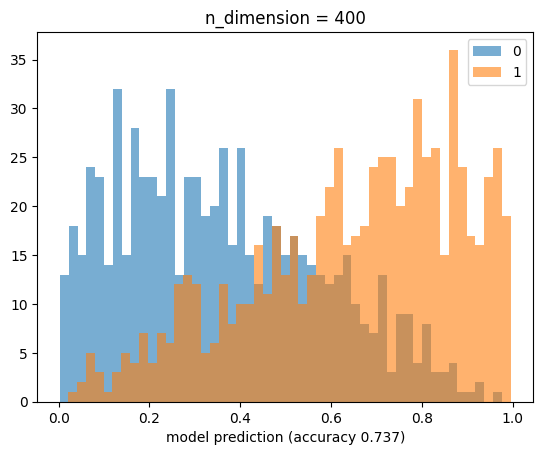

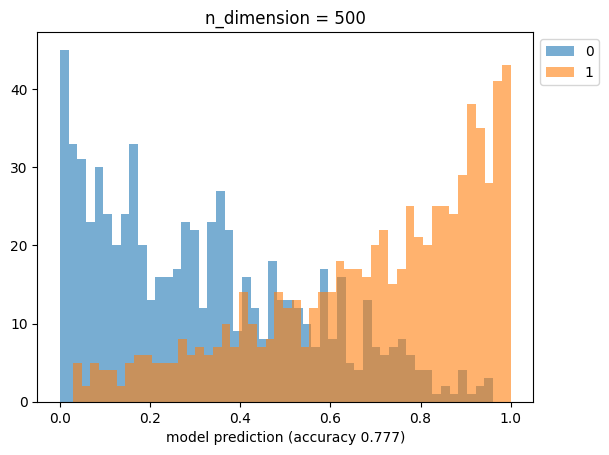

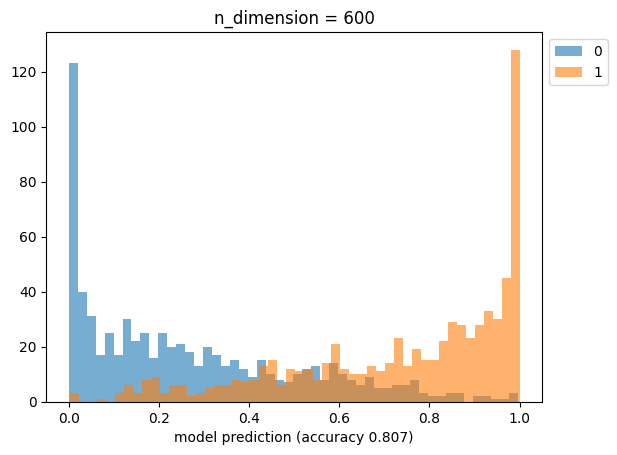

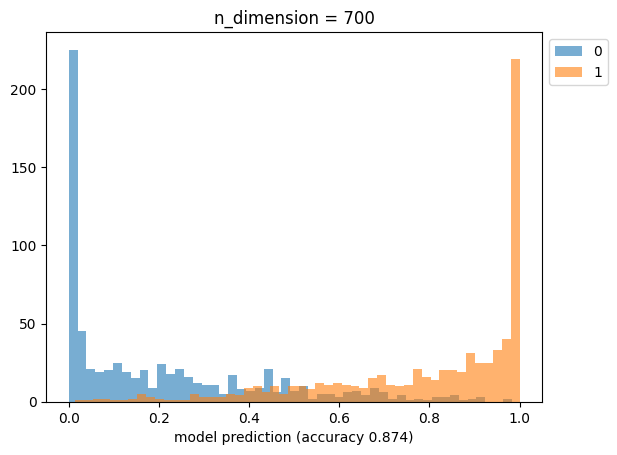

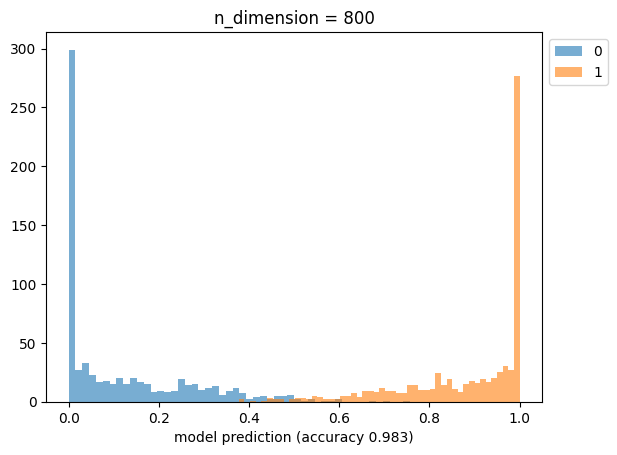

In [4]:
for n_dimension in list(range(10,100,10))+list(range(100,801,100)):

    train_w_N_dim = train_df.iloc[:, :n_dimension].copy()
    model.fit(train_w_N_dim, train_df['target'])
    train_w_N_dim.loc[:, 'pred_prob'] = model.predict_proba(train_w_N_dim.iloc[:,:n_dimension])[:,1]
    train_w_N_dim.loc[:, 'pred'] = model.predict(train_w_N_dim.iloc[:,:n_dimension])
    
    for group in [0,1]:
        plt.hist(train_w_N_dim.loc[train_df['target']==group, 'pred_prob'],
                   label=group, alpha=0.6, bins=50)
        plt.legend(bbox_to_anchor=(1, 1))
    acc = round(accuracy_score(train_df['target'], train_w_N_dim['pred']),3)
    plt.xlabel(f'model prediction (accuracy {acc})')
    plt.title(f'n_dimension = {n_dimension}') # .set_title('Axis [0, 0]')
    plt.show()

In [5]:
model.fit(train_df.iloc[:,:-1], train_df['target'])
accuracy_score(train_df['target'], model.predict(train_df.iloc[:,:-1]))

1.0

In [6]:
accuracy_score(test_df['target'], model.predict(test_df.iloc[:,:-1]))

0.48333333333333334

### F2 -  Mi lenne ha - a lehetséges kombinációk számának megértése / megérzése
Tegyük fel hogy:
- Egy tanítási és tesztelési, kiértékelési ciklus 10ms alatt lefut
- Rendelkezésünkre áll Magyarország összes számítógépe, mondjuk 10 millió számítógép 
- A 64 elemű változólistából minden kombinációt ki akarunk próbálni, kivéve azt, amikor az összes elemet kizárjuk a bemeneti változók közül.

__KÉRDÉS__: Mennyi ideig tartana kipróbálni az összes lehetséges kombinációt ennyi gépen?

In [7]:
verziok_szama=2**64-1

masodpercenkenti_modell_epites_es_kiertekeles = 1000/10
szamitogepek_szama = 10**7
egygepen=verziok_szama/szamitogepek_szama
ido_mp = egygepen/masodpercenkenti_modell_epites_es_kiertekeles
ido_perc=ido_mp/60
ido_ora =ido_perc/60
ido_nap =ido_ora/24
ido_ev = ido_nap/365
ido_ev

584.9424173550719

## F3 - változókiválasztási módszerek összevetéséhez summary baseline-nal

In [8]:
from sklearn.datasets import load_digits

digits=load_digits(as_frame=True)
X = digits.data
y = digits.target

In [9]:
X.head(2)

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0


In [10]:
from sklearn.metrics import log_loss, roc_auc_score

In [11]:
def add_to_summary(summary, X_train, X_test, y_train, y_test, method, model):
    model.fit(X_train, y_train)

    summary.loc[method, 'Logloss - train'] = log_loss(y_train, model.predict_proba(X_train))
    summary.loc[method, 'Logloss - test'] = log_loss(y_test, model.predict_proba(X_test))
    summary.loc[method, 'n_features'] = len(X_train.columns)
    summary.loc[method, 'features'] = list(X_train.columns)
    print(summary.loc[method])

    return summary, model

summary = pd.DataFrame(columns=['Logloss - train', 'Logloss - test', 'n_features', 'features'])

In [12]:
print(X.dtypes.value_counts())

float64    64
dtype: int64


In [13]:
X.columns[X.isnull().sum()!=0]

Index([], dtype='object')

In [14]:
model = LogisticRegression(max_iter=10000) # Avoid 'ConvergenceWarning: lbfgs failed to converge'

y = digits.target == 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

summary, trained_model = add_to_summary(summary, X_train, X_test, y_train, y_test, method = 'baseline', model=model)

Logloss - train                                              0.00528
Logloss - test                                              0.113392
n_features                                                        64
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: baseline, dtype: object


In [15]:
from random import sample
from random import seed
seed(42)
example = [1,2,3,4]
sample(example,2)

[1, 4]

In [16]:
seed(42)
subset32=sample(list(X_train.columns),32)

In [17]:
summary, trained_model = add_to_summary(summary, X_train[subset32], X_test[subset32], y_train, y_test, method = 'random32', model=model)

Logloss - train                                              0.08531
Logloss - test                                              0.117683
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object


In [18]:
summary

,Logloss - train,Logloss - test,n_features,features
baseline,0.00528,0.113392,64,"[pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p..."
random32,0.08531,0.117683,32,"[pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p..."


Egy tanítási-tesztelési ciklus idejének lemérése a %timeit paranccsal

In [19]:
%timeit add_to_summary(summary, X_train[subset32], X_test[subset32], y_train, y_test, method = 'random32', model=model)

Logloss - train                                              0.08531
Logloss - test                                              0.117683
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object
Logloss - train                                              0.08531
Logloss - test                                              0.117683
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object
Logloss - train                                              0.08531
Logloss - test                                              0.117683
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object
Logloss - train                                              0.08531
Logloss - tes

### Dimenziók átkának megjelenése az adott adathalmaznál

In [19]:
X_train_with_rnd = X_train.join(fake_df.drop('target', axis=1), how='left')
X_test_with_rnd = X_test.join(fake_df.drop('target', axis=1), how='left')

model = LogisticRegression(max_iter=1000, random_state=42, C=10000) # Avoid 'ConvergenceWarning: lbfgs failed to converge'
summary, trained_model = add_to_summary(summary, X_train_with_rnd, X_test_with_rnd, y_train, y_test, method='dim_atok', model=model)


Logloss - train                                             0.000025
Logloss - test                                              0.091569
n_features                                                      1064
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: dim_atok, dtype: object


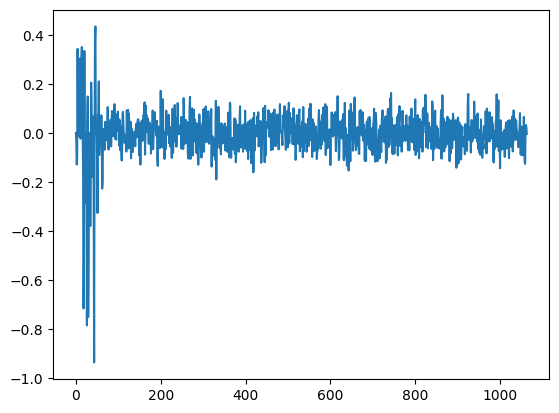

In [20]:
plt.plot(trained_model.coef_[0]);

## F4 - Korreláció alapú szelekció

In [37]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_predict

In [32]:
model = LogisticRegression(max_iter=1000, random_state=42)
corrs_to_y = abs(pd.concat([X_train, y_train], axis=1).corr()['target']).sort_values(ascending=False)
corrs_to_y = corrs_to_y.drop('target')
corrs_to_y

pixel_3_2    0.426025
pixel_4_2    0.360612
pixel_2_2    0.354472
pixel_5_3    0.325953
pixel_2_4    0.278792
               ...   
pixel_7_0    0.009734
pixel_1_6    0.006150
pixel_0_0         NaN
pixel_4_0         NaN
pixel_4_7         NaN
Name: target, Length: 64, dtype: float64

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:24<00:00,  2.56it/s]


Logloss - train                                             0.029841
Logloss - test                                              0.058254
n_features                                                        24
features           [pixel_3_2, pixel_4_2, pixel_2_2, pixel_5_3, p...
Name: top-corr, dtype: object


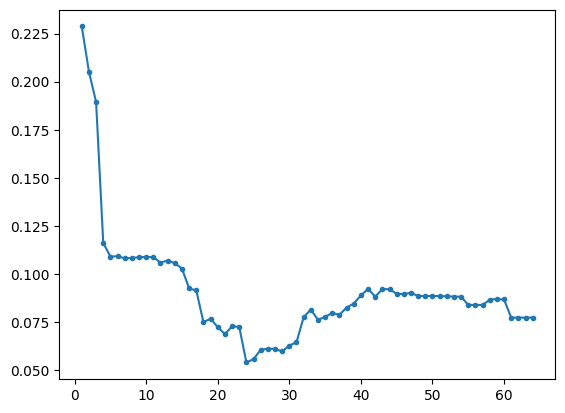

In [33]:
corr_based_topX = pd.DataFrame()

for top_x in tqdm(range(1, len(X.columns)+1)):

    # kivalasztjuk elso X legjobban korrelalo valtozot
    selected_vars = [item for item in corrs_to_y[:top_x].index]
    pred_proba = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:,1]
    corr_based_topX.loc[top_x, 'Logloss'] = log_loss(y_train, pred_proba)

corr_based_topX['Logloss'].plot(marker='.')

best_n_features_based_on_logloss = corr_based_topX['Logloss'].idxmin()
selected_vars = [item for item in corrs_to_y[:best_n_features_based_on_logloss].index if item!='y']
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method='top-corr', model=model)

In [34]:
corr_based_topX['Logloss'].min()

0.05393262416447886

## F5 - Forward selection módszere

In [26]:
model = LogisticRegression(max_iter=1000, random_state=42)

### A) ELSŐ ESET: Manual

In [27]:
kivalasztott_valtozok=[]
meg_nem_kivalasztottak=list(X_train.columns)
best_logloss_list=[]
best_logloss = 9999999999
for elemszam in tqdm(range(0,len(X_train.columns))):
    best_var = ""
    for v in (meg_nem_kivalasztottak):
        used_features = kivalasztott_valtozok + [v]
        pred = cross_val_predict(model, X_train[used_features], y_train, cv=4, method='predict_proba')
        logloss = log_loss(y_train, pred)
        if logloss<best_logloss:
            best_var = v
            best_logloss=logloss
            # print("\tValaki jobb: ", best_var, best_logloss)
    if best_var!="":
        meg_nem_kivalasztottak.remove(best_var)
        kivalasztott_valtozok.append(best_var)
        best_logloss_list.append(best_logloss)
        print(kivalasztott_valtozok,best_logloss)
    else:
        print(f"\n FINISHED because there is no progress by adding any of the followings: {meg_nem_kivalasztottak}")
        break

  2%|█▎                                                                                 | 1/64 [00:02<02:32,  2.43s/it]

['pixel_3_2'] 0.22871335971146636


  3%|██▌                                                                                | 2/64 [00:04<02:31,  2.45s/it]

['pixel_3_2', 'pixel_5_3'] 0.1349631432950365


  5%|███▉                                                                               | 3/64 [00:07<02:30,  2.47s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6'] 0.09623065200652256


  6%|█████▏                                                                             | 4/64 [00:10<02:36,  2.62s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4'] 0.08205019972757696


  8%|██████▍                                                                            | 5/64 [00:13<02:44,  2.78s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6'] 0.07134513123697597


  9%|███████▊                                                                           | 6/64 [00:16<02:41,  2.79s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6'] 0.06379547338476761


 11%|█████████                                                                          | 7/64 [00:19<02:51,  3.00s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5'] 0.05655989003276956


 12%|██████████▍                                                                        | 8/64 [00:22<02:54,  3.11s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2'] 0.04821509188594553


 14%|███████████▋                                                                       | 9/64 [00:26<02:53,  3.16s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2'] 0.044307069441220134


 16%|████████████▊                                                                     | 10/64 [00:30<03:02,  3.38s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5'] 0.040661515776918816


 17%|██████████████                                                                    | 11/64 [00:39<04:39,  5.27s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4'] 0.03825356833572161


 19%|███████████████▍                                                                  | 12/64 [00:49<05:53,  6.80s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5'] 0.03657680665039376


 20%|████████████████▋                                                                 | 13/64 [01:00<06:53,  8.11s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6'] 0.03540401100441067


 22%|█████████████████▉                                                                | 14/64 [01:12<07:29,  8.99s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3'] 0.03433353336859787


 23%|███████████████████▏                                                              | 15/64 [01:23<07:55,  9.70s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1'] 0.033442571111581325


 25%|████████████████████▌                                                             | 16/64 [01:37<08:47, 11.00s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_1'] 0.033358736985982594


 27%|█████████████████████▊                                                            | 17/64 [01:52<09:35, 12.24s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_1', 'pixel_5_0'] 0.03327079312624937


 27%|█████████████████████▊                                                            | 17/64 [02:07<05:52,  7.49s/it]


 FINISHED because there is no progress by adding any of the followings: ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_5', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_3', 'pixel_3_4', 'pixel_3_7', 'pixel_4_0', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_1', 'pixel_5_4', 'pixel_5_5', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_6', 'pixel_6_7', 'pixel_7_0', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_7']


In [28]:
summary, trained_model = add_to_summary(summary, X_train[kivalasztott_valtozok], X_test[kivalasztott_valtozok], y_train, y_test, method='manual-Forward', model=model)

Logloss - train                                             0.021749
Logloss - test                                              0.071377
n_features                                                        17
features           [pixel_3_2, pixel_5_3, pixel_3_6, pixel_0_4, p...
Name: manual-Forward, dtype: object


In [29]:
summary

,Logloss - train,Logloss - test,n_features,features
baseline,0.00528,0.113392,64,"[pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p..."
random32,0.08531,0.117683,32,"[pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p..."
dim_atok,0.000025,0.091569,1064,"[pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p..."
top-corr,0.029841,0.058254,24,"[pixel_3_2, pixel_4_2, pixel_2_2, pixel_5_3, p..."
manual-Forward,0.021749,0.071377,17,"[pixel_3_2, pixel_5_3, pixel_3_6, pixel_0_4, p..."


### B) SequentialFeatureSelector fixált n_feature esetén

In [30]:
from sklearn.metrics import make_scorer
LogLoss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

C:\Users\Lenovo\anaconda3\envs\energy\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [31]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(model, n_features_to_select=len(kivalasztott_valtozok), scoring=LogLoss_scorer, cv=4, direction='forward')
sfs.fit(X_train, y_train)

cols_from_sfs = X_train.columns[sfs.get_support()]

In [32]:
print('eltérés a manual és implementált között:')
print(set(kivalasztott_valtozok) - (set(cols_from_sfs)))
print(set(cols_from_sfs) - (set(kivalasztott_valtozok)))

eltérés a manual és implementált között:
{'pixel_7_1', 'pixel_5_0'}
{'pixel_6_0', 'pixel_4_0'}


In [33]:
sfs.get_support()

array([False, False, False, False,  True, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
        True,  True,  True, False, False, False, False, False,  True,
       False, False,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False])

## C) SequentialFeatureSelector auto n_feature esetén

In [34]:
from sklearn.feature_selection import SequentialFeatureSelector
from datetime import datetime as datetime
start = datetime.now()

sfs = SequentialFeatureSelector(model, n_features_to_select='auto', scoring=LogLoss_scorer,
                                cv=4, direction='forward', tol = 0.00000001)
sfs.fit(X_train, y_train)

cols_from_sfs = X_train.columns[sfs.get_support()]

time_spent = str(datetime.now()-start)
print(f'SFS time to found best n_features ({len(cols_from_sfs)}) : {time_spent} ')

SFS time to found best n_features (16) : 0:01:51.220360 


In [35]:
summary, trained_model = add_to_summary(summary, X_train[cols_from_sfs], X_test[cols_from_sfs], y_train, y_test, method='forward_sfs', model=model)

Logloss - train                                             0.022666
Logloss - test                                              0.065758
n_features                                                        16
features           [pixel_0_4, pixel_0_6, pixel_1_5, pixel_2_2, p...
Name: forward_sfs, dtype: object


## F6 - Recursive feature elimination (RFE)

In [36]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

min_features_to_select=1
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring=LogLoss_scorer,
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train.values, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 15


In [37]:
rfecv.cv_results_

{'mean_test_score': array([-0.28197458, -0.21815636, -0.16106022, -0.11773972, -0.09773735,
        -0.08805169, -0.08075001, -0.08017941, -0.08171074, -0.08890449,
        -0.08948941, -0.08373415, -0.07768613, -0.0807239 , -0.07597346,
        -0.07628282, -0.07652163, -0.07880298, -0.08385183, -0.08395897,
        -0.09170395, -0.09627553, -0.09609176, -0.09794683, -0.09636637,
        -0.09195602, -0.08541579, -0.08749281, -0.0868688 , -0.08832315,
        -0.08910293, -0.08561644, -0.08821282, -0.08819937, -0.08673664,
        -0.08605845, -0.08760611, -0.0860962 , -0.08605592, -0.08618661,
        -0.08582239, -0.08436495, -0.08399087, -0.08287813, -0.08315718,
        -0.08349203, -0.08397078, -0.0834437 , -0.08347214, -0.08344921,
        -0.08324787, -0.08323957, -0.08343537, -0.08344764, -0.08367053,
        -0.08316699, -0.08334563, -0.08301784, -0.0831572 , -0.08331391,
        -0.0833178 , -0.08349086, -0.08353633, -0.08333145]),
 'std_test_score': array([0.0066068 , 0.027

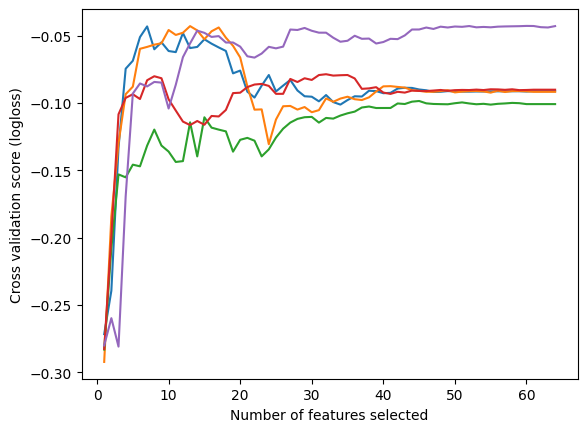

In [38]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (logloss)")
split_scores_names = [split_test_score for split_test_score in rfecv.cv_results_.keys() if split_test_score.startswith('split')]
for splitX_test_score in split_scores_names:
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_[splitX_test_score]) + min_features_to_select),
        rfecv.cv_results_[splitX_test_score],
    )
plt.show()

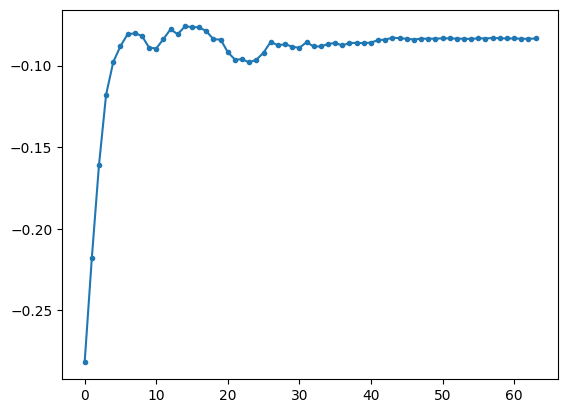

In [39]:
plt.plot(rfecv.cv_results_['mean_test_score'],marker='.')

In [40]:
RFECV_selected_vars = list(X_train.columns[rfecv.support_])
summary, trained_model = add_to_summary(summary, X_train[RFECV_selected_vars], X_test[RFECV_selected_vars], y_train, y_test, method='RFE', model=model)

Logloss - train                                             0.018417
Logloss - test                                              0.116165
n_features                                                        15
features           [pixel_0_3, pixel_0_4, pixel_1_2, pixel_1_4, p...
Name: RFE, dtype: object


## F7 - Model alapú megoldások - Logisztikus regresszió coeficiennsei 

<Axes: >

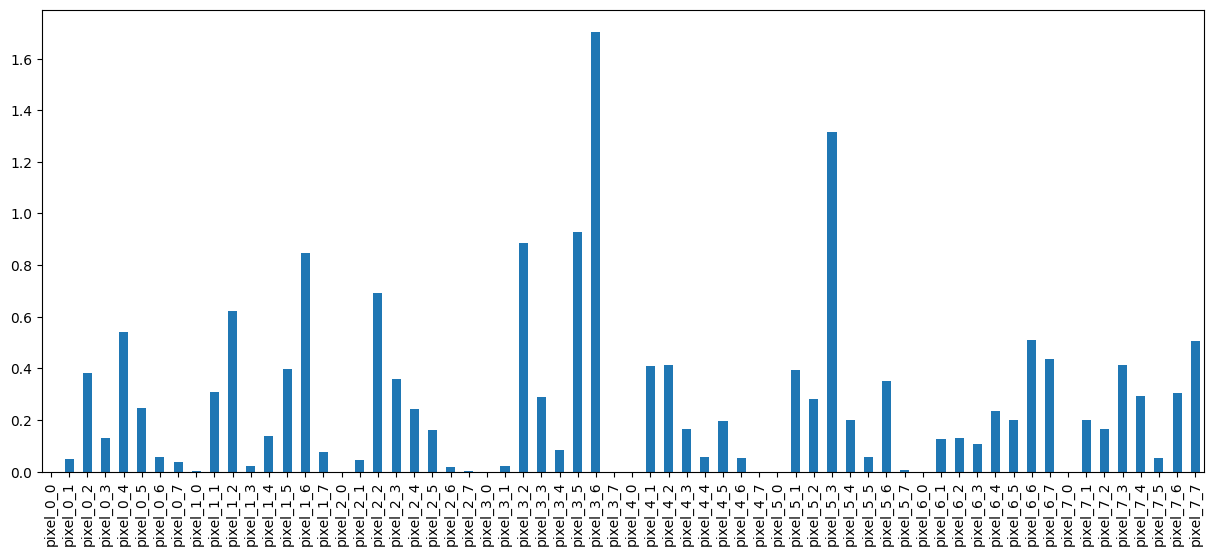

In [41]:
plt.rcParams["figure.figsize"] = (15,6)
model = LogisticRegression(max_iter=10000, random_state=42)

model.fit(X_train, y_train)

var_coefs = pd.Series(model.coef_[0], index=X_train.columns).apply(abs)
var_coefs.plot.bar()

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:23<00:00,  2.68it/s]


<Axes: >

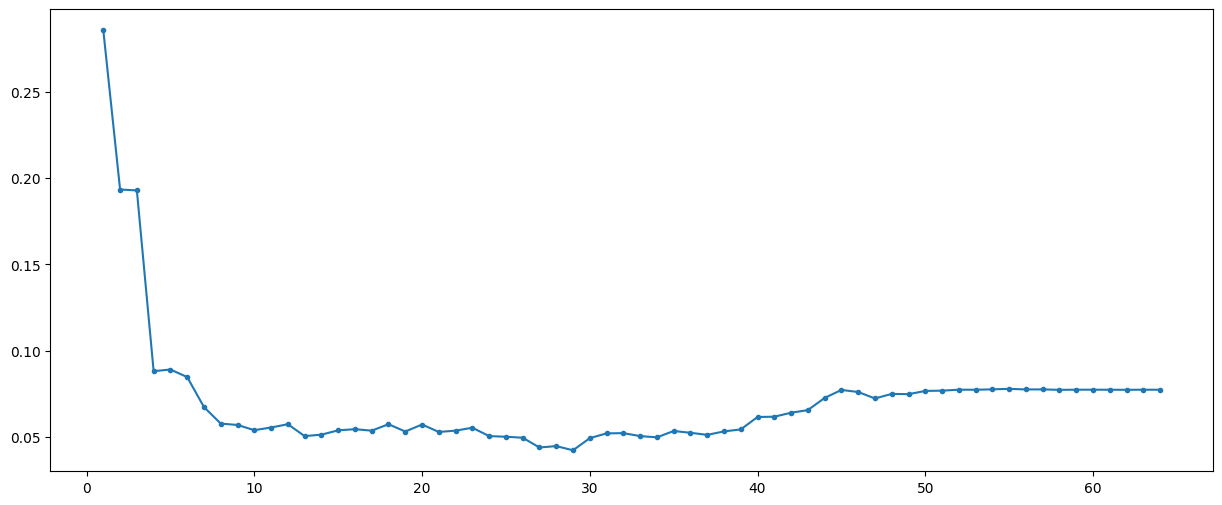

In [42]:
coef_based_topX = pd.DataFrame()
vars_sorted_by_coef = list(var_coefs.sort_values(ascending=False).index)
for top_x in tqdm(range(1, len(vars_sorted_by_coef)+1)):
    selected_vars = vars_sorted_by_coef[:top_x]
    pred_proba = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:,1]
    coef_based_topX.loc[top_x, 'Logloss'] = log_loss(y_train, pred_proba)

coef_based_topX['Logloss'].plot(marker='.')

In [43]:
best_n_features = coef_based_topX['Logloss'].idxmin()
selected_vars = vars_sorted_by_coef[:best_n_features]
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method=f'model_based_logreg', model=model)

Logloss - train                                              0.00817
Logloss - test                                              0.097225
n_features                                                        29
features           [pixel_3_6, pixel_5_3, pixel_3_5, pixel_3_2, p...
Name: model_based_logreg, dtype: object


## F8 - Változó kiválasztás lasso regresszió segítségével

$ célfüggvény = ModellHibájaAPontokon + \frac{1}{C}*ModellKomplexitás = ModellHibájaAPontokon + \frac{1}{C} * \sum_{i=1}^{m}|\alpha_i|$

In [44]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 5, 10, 25, 50, 100]

logloss_df = pd.DataFrame()
for C in tqdm(Cs):
    model_for_lasso = LogisticRegression(solver='saga', max_iter=1000, penalty='l1', C=C, random_state=42)
    pred_proba = cross_val_predict(model_for_lasso, X_train, y_train, cv=4, method='predict_proba')[:,1]
    logloss_df.loc[C, 'Logloss'] = log_loss(y_train, pred_proba)

    model_for_lasso.fit(X_train, y_train)
    selected_vars = list(X_train.columns[model_for_lasso.coef_[0]!=0])
    logloss_df.loc[C, 'selected_vars'] = [[selected_vars]]
    logloss_df.loc[C, 'n_selected_vars'] = len(selected_vars)

 15%|████████████▊                                                                      | 2/13 [00:10<00:58,  5.35s/it]C:\Users\Lenovo\anaconda3\envs\energy\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\energy\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\energy\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|███████████████████▏                                                               | 3/13 [00:18<01:05,  6.56s/it]C:\Users\Lenovo\anaconda3\envs\energy\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn

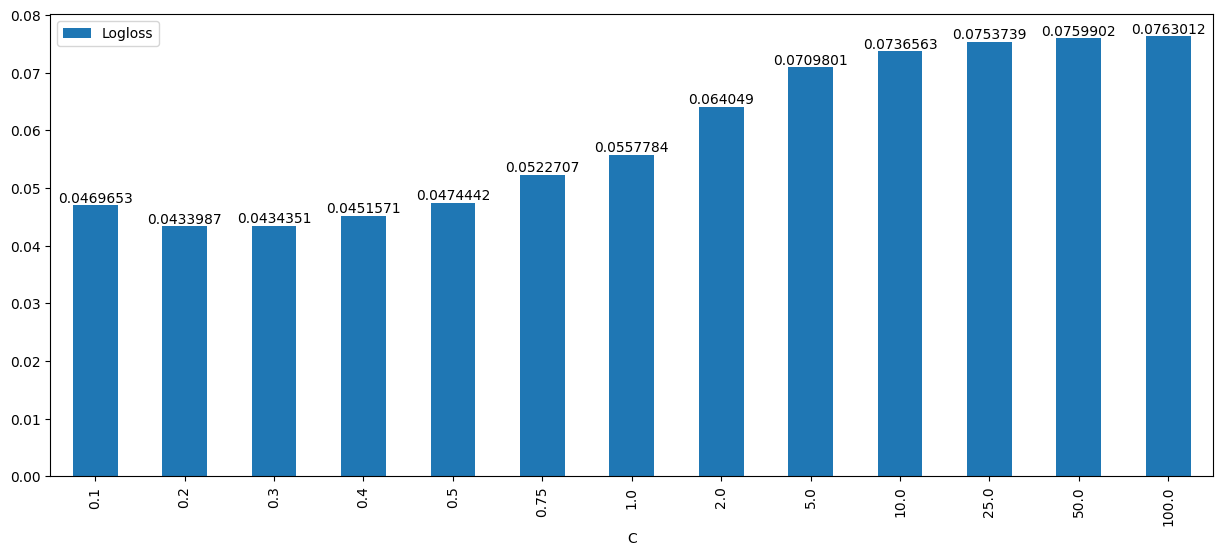

In [45]:
ax = logloss_df.reset_index().rename(columns = {'index':'C'}).plot.bar(x='C', y='Logloss')
ax.bar_label(ax.containers[0]);

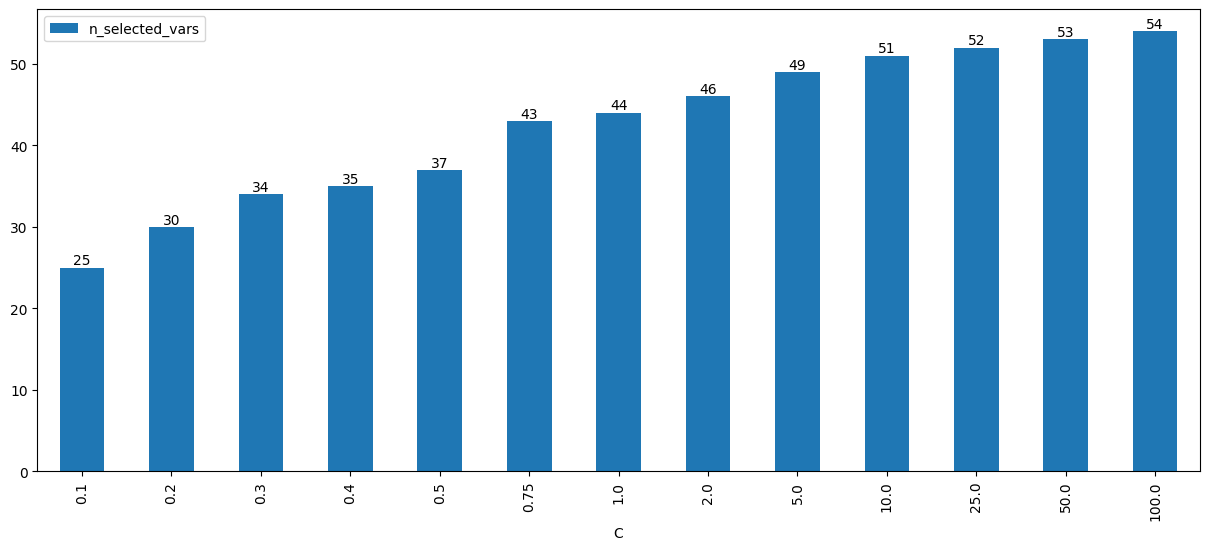

In [46]:
ax = logloss_df.reset_index().rename(columns = {'index':'C'}).plot.bar(x='C', y='n_selected_vars')
ax.bar_label(ax.containers[0]);

In [47]:
best_C = logloss_df['Logloss'].idxmin()
print(f'Best C is {best_C}')

selected_vars_for_best_C = logloss_df.loc[best_C, 'selected_vars']
selected_by_lasso = selected_vars_for_best_C[0][0]

Best C is 0.2


In [48]:
model = LogisticRegression(max_iter=1000, random_state=42)
summary, model_trained = add_to_summary(summary, X_train[selected_by_lasso], X_test[selected_by_lasso], y_train, y_test, method=f'lasso', model=model)

Logloss - train                                             0.007014
Logloss - test                                              0.099499
n_features                                                        30
features           [pixel_0_2, pixel_0_3, pixel_0_4, pixel_1_1, p...
Name: lasso, dtype: object



## F9 - model_based (gbm + feature_importance)

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=600, max_depth=3, random_state=42, learning_rate=0.1)
summary, trained_model = add_to_summary(summary, X_train, X_test, y_train, y_test, method = 'gbm_bl', model=gbm)
var_imps = pd.Series(trained_model.feature_importances_, index=X_train.columns)
n_of_vars_with_zero_importance = (var_imps==0).sum()
print(f'\nn features with zero importance = {n_of_vars_with_zero_importance}')

Logloss - train                                                  0.0
Logloss - test                                              0.067477
n_features                                                        64
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: gbm_bl, dtype: object

n features with zero importance = 14


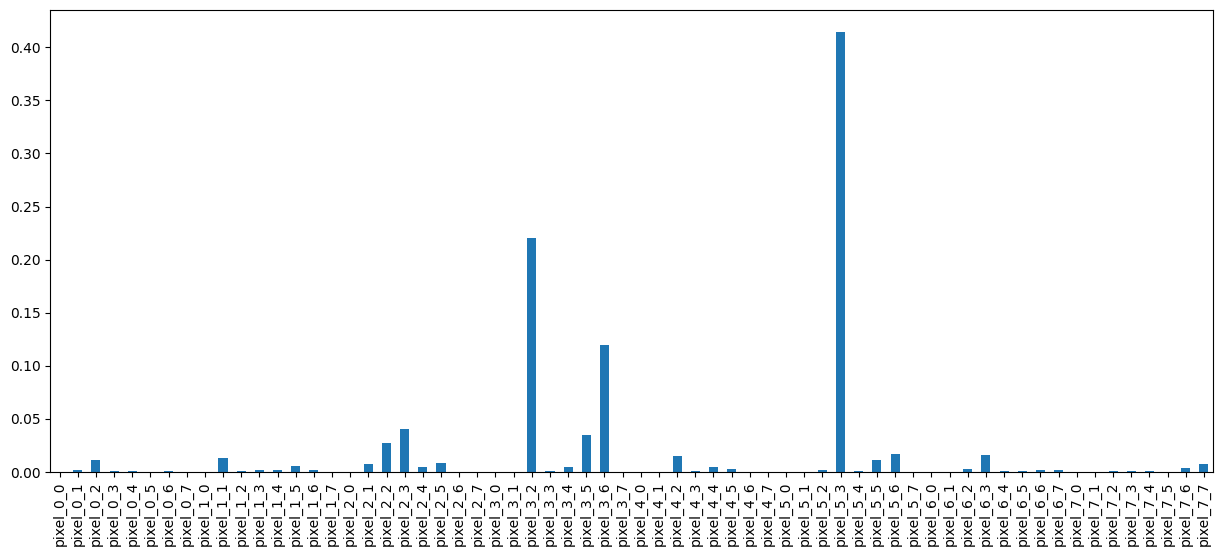

In [50]:
var_imps = pd.Series(trained_model.feature_importances_, index=X_train.columns)
var_imps.plot.bar()
plt.rcParams["figure.figsize"] = (20,10)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [16:49<00:00, 15.77s/it]


Logloss - train                                                  0.0
Logloss - test                                              0.067684
n_features                                                        29
features           [pixel_5_3, pixel_3_2, pixel_3_6, pixel_2_3, p...
Name: model_based_gbm, dtype: object


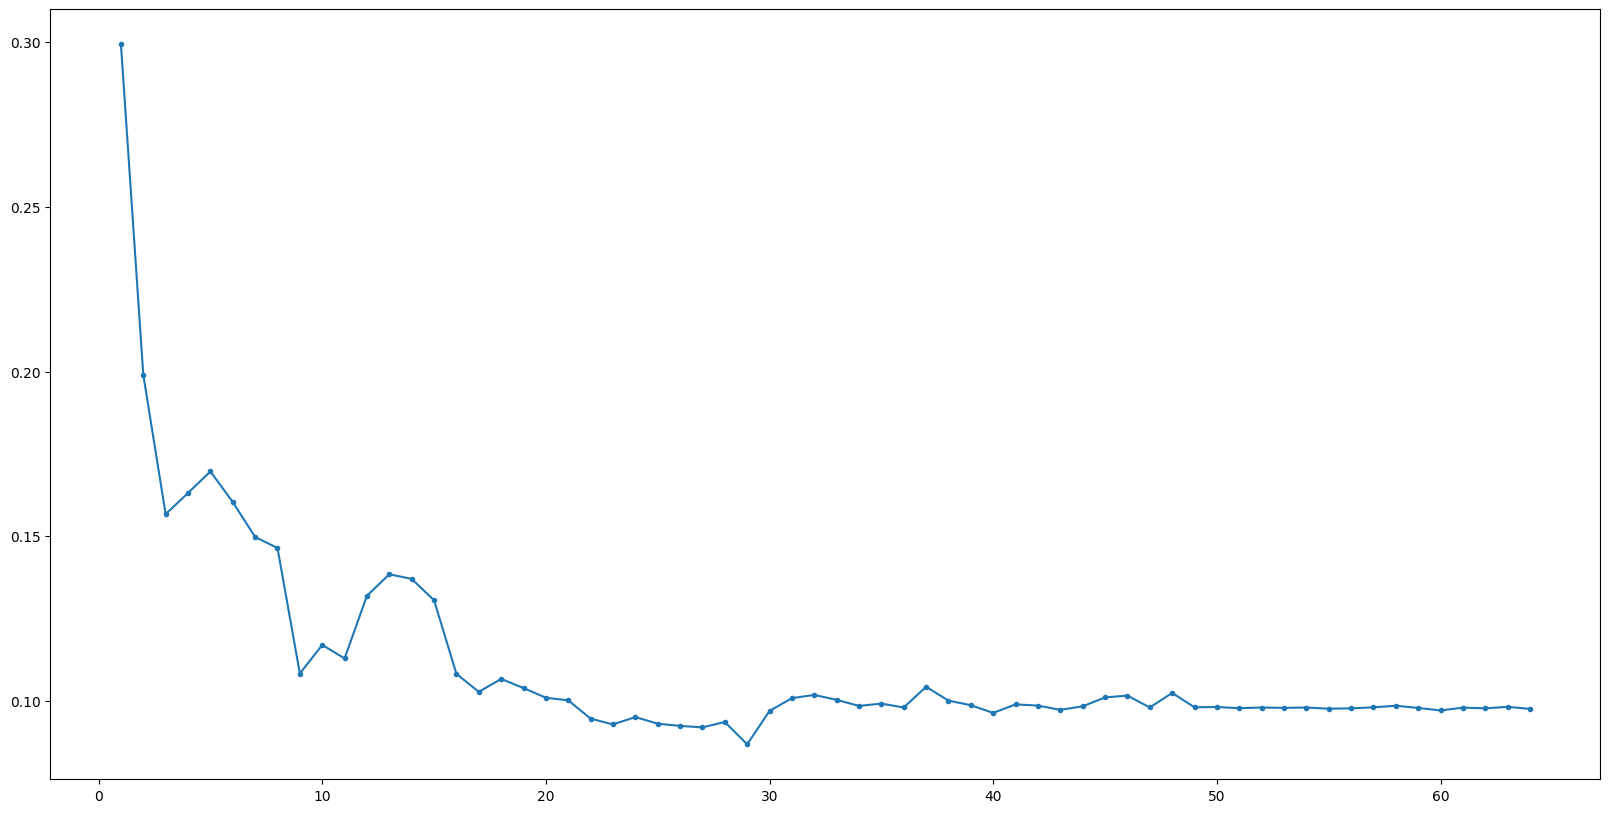

In [51]:
imp_based_topX = pd.DataFrame()
vars_sorted_by_imp = list(var_imps.sort_values(ascending=False).index)
for top_x in tqdm(range(1, len(vars_sorted_by_imp)+1)):
    selected_vars = vars_sorted_by_imp[:top_x]
    pred_proba = cross_val_predict(gbm, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:,1]
    imp_based_topX.loc[top_x, 'Logloss'] = log_loss(y_train, pred_proba)

imp_based_topX['Logloss'].plot(marker='.')

best_n_features = imp_based_topX['Logloss'].idxmin()
selected_vars = vars_sorted_by_imp[:best_n_features]
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method=f'model_based_gbm', model=gbm)

## F10 - Generativ algoritmus

In [28]:
from datetime import datetime as datetime
np.random.seed(42)
import random

random.seed(42)

In [29]:
def create_initial_population(n_features, size):
    population = []
    for _ in range(size):
        exemplar = np.random.randint(0, 2, n_features)

        population.append(exemplar)
    return population

In [30]:
import warnings
warnings.filterwarnings("ignore")

model = LogisticRegression(random_state=42)

In [31]:
def fitness_function(exemplar):
    exemplar = np.array(exemplar)
    selected_vars = X_train.columns[exemplar==1]
    probas = cross_val_predict(model, X_train[selected_vars], y_train, cv=2, method='predict_proba')
    exemplar_logloss = log_loss(y_train, probas)

    return -1*exemplar_logloss  # Negate to minimize curviness

In [32]:
# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=3):
    tournament_size = min(tournament_size, len(population))
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

In [33]:
# Crossover function
def crossover(parent1, parent2, debug=False):
    x1 = random.randint(0, len(parent1)-1)
    x2 = random.randint(x1+1, len(parent1))
    child1=list(parent1[:x1])+list(parent2[x1:x2])+list(parent1[x2:])
    child2=list(parent2[:x1])+list(parent1[x1:x2])+list(parent2[x2:])
    if debug is True:
        return child1, child2, x1, x2
    else:
        return child1, child2

In [34]:
def mutation(individual, mutation_rate):
    return [gene if random.random() > mutation_rate else 1 - gene for gene in individual]

In [35]:
# Main genetic algorithm function
def genetic_algorithm(population_size, generations, runtime_limit_in_seconds, mutation_rate):
    # Genetic algorithm to transform hourly data to 15-minute data
    # population_size: number of individuals in the population in genetic algorithm (int)
    # generations: number of generations in genetic algorithm (int)
    # runtime_limit_in_seconds: runtime limit in seconds (int)
    # mutation_rate: mutation rate in genetic algorithm (float)
    # data_hourly: hourly data to be transformed (list of 24 floats)
    # figure_dir: directory to save figures of the best performer of each generation (str), if it is None, the figures will not be saved
    start_time = datetime.now()

    population = create_initial_population(64, 100)

    best_fitness = float("-inf")
    all_populations = []
    for generation in range(generations):
        if generation%1==0:
            print(f"Generation {generation + 1} - Best fitness: {best_fitness}")
        if generation > 5:
            now = datetime.now()
            if (now-start_time).seconds > runtime_limit_in_seconds:
                print("Runtime limit reached")
                break
       
        exemplar_fitness_pairs = [(ind, fitness_function(ind)) for ind in population]
        best_individual, best_fitness = max(exemplar_fitness_pairs, key=lambda x: x[1])

        all_populations.append(population[:])
        population, fitnesses = zip(*exemplar_fitness_pairs)
        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            child1, child2 = crossover(parent1, parent2)
            
            next_population.append(mutation(child1, mutation_rate))
            next_population.append(mutation(child2, mutation_rate))

        # Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    final_population = all_populations[-1]
    final_fitnesses = [fitness_function(ind) for ind in final_population]
    
    return max(population, key=fitness_function)

In [38]:
x=genetic_algorithm(population_size=20,
        generations=25,
        runtime_limit_in_seconds=120,
        mutation_rate=0.05)

Generation 1 - Best fitness: -inf
Generation 2 - Best fitness: -0.061141623553456155
Generation 3 - Best fitness: -0.05583430904487887
Generation 4 - Best fitness: -0.051336571706230266
Generation 5 - Best fitness: -0.04089275234781809
Generation 6 - Best fitness: -0.03829355257505821
Generation 7 - Best fitness: -0.03829355257505821
Generation 8 - Best fitness: -0.03829355257505821
Generation 9 - Best fitness: -0.038163915352865944
Runtime limit reached


In [66]:
selected_vars = X_train.columns[np.array(x)==1]

In [67]:
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method=f'generic_algo', model=model)

Logloss - train                                             0.017403
Logloss - test                                              0.103316
n_features                                                        34
features           [pixel_0_1, pixel_0_3, pixel_0_4, pixel_1_0, p...
Name: generic_algo, dtype: object


## F11 - melyik pixelt választják ki legtöbbször a különböző módszerek?

In [52]:
methods = ['top-corr', 'manual-Forward', 'RFE', 'model_based_logreg', 'lasso']
selected_vars_all = summary.loc[methods, 'features'].tolist()
falttened_selected_vars_all = [selected_feature for selected_features in selected_vars_all for selected_feature in selected_features]

In [53]:
selected_times={}
for pixel in X_train.columns:
    selected_times[pixel]=0

In [54]:
for used_pixel in falttened_selected_vars_all:
    selected_times[used_pixel]=selected_times[used_pixel]+1

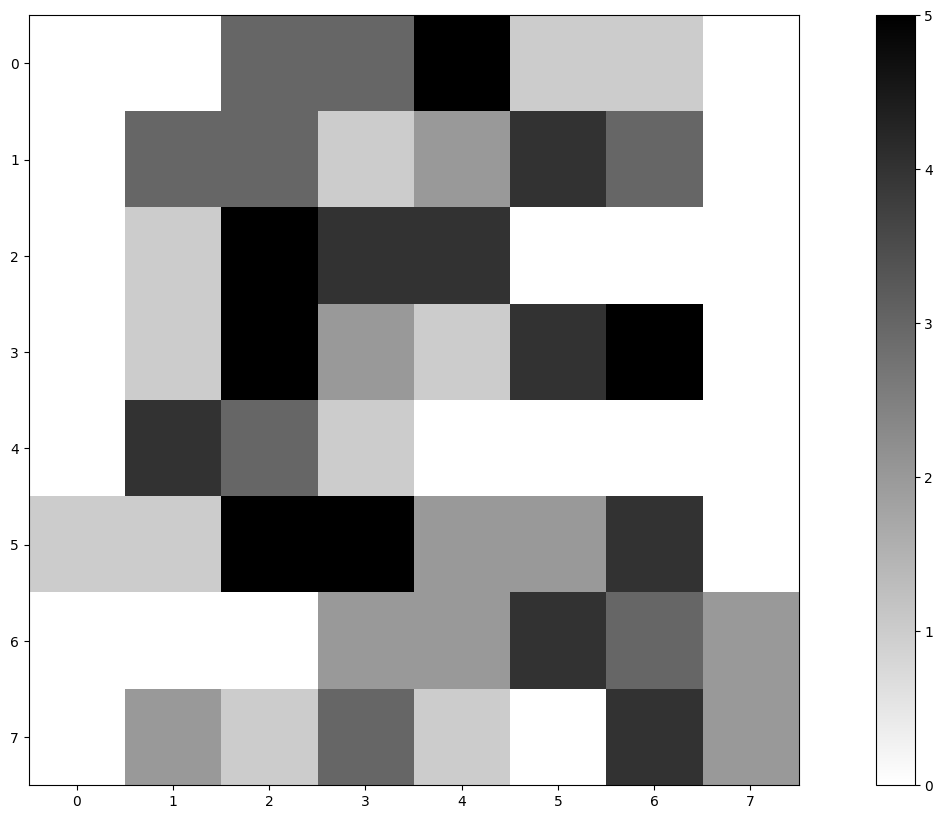

In [55]:
plt.imshow(np.array(list(selected_times.values())).reshape(8, 8), cmap='gray_r')
plt.colorbar()

In [56]:
[i for i in selected_times.values() if i == 5]

[5, 5, 5, 5, 5, 5]

## Konklúzió - vizualizáljuk az egyes módszerekkel kiválasztott pixelek milyen súllyal kerülnek be a modellbe

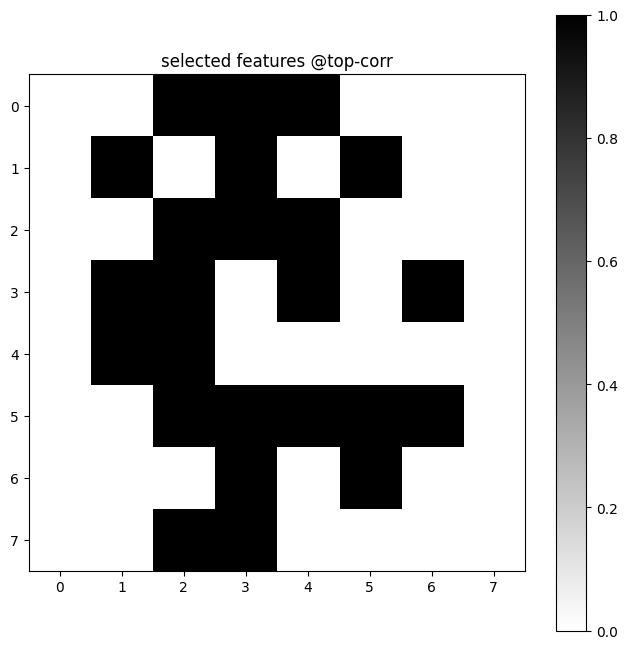

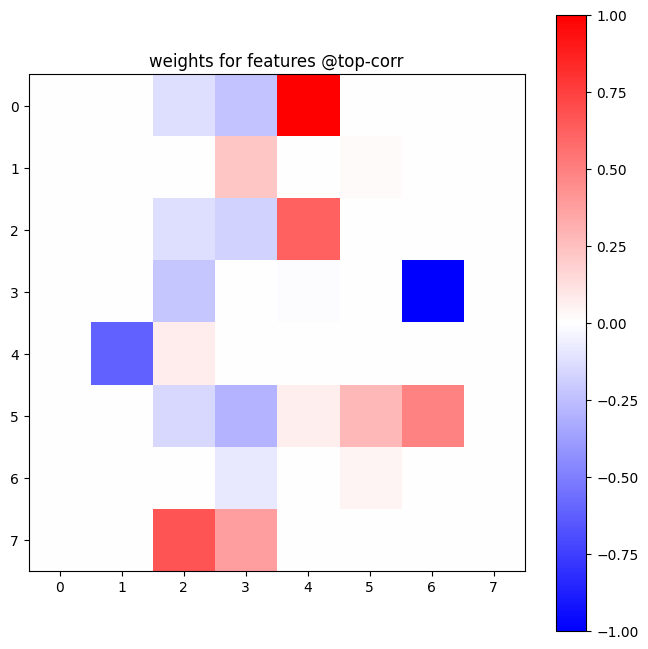

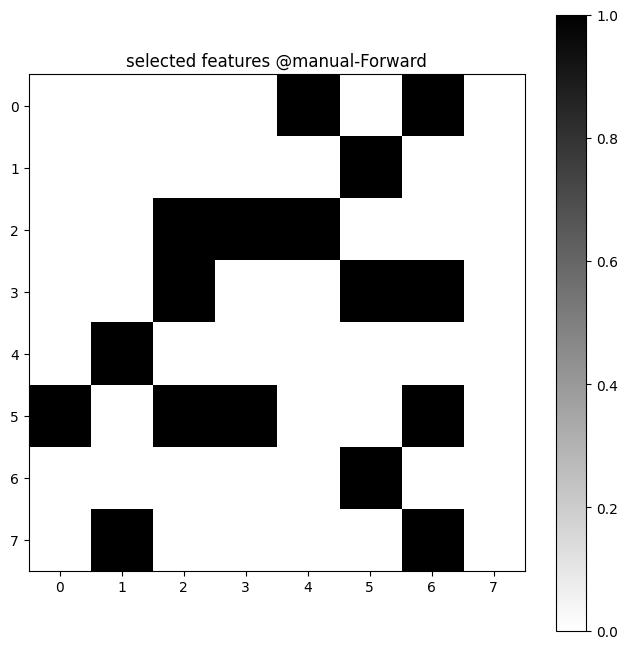

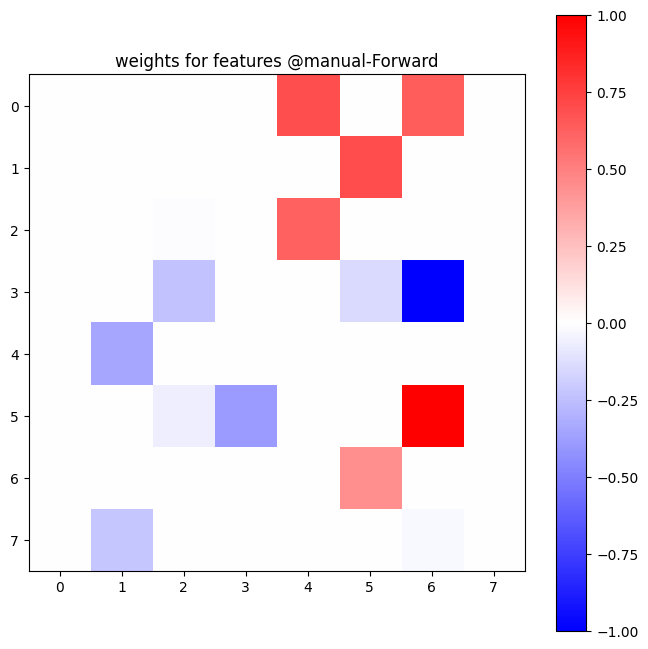

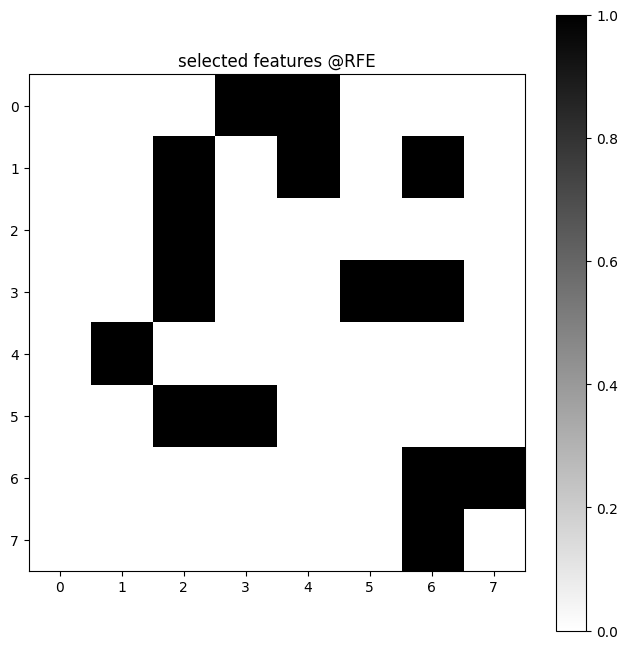

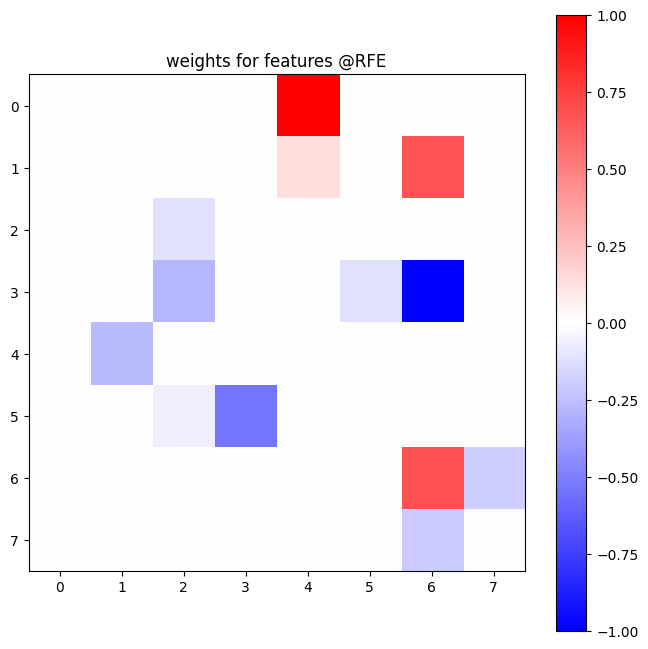

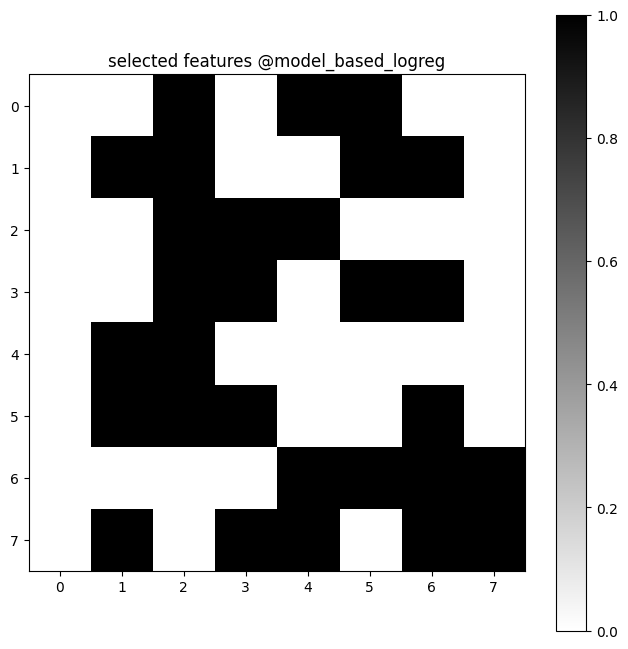

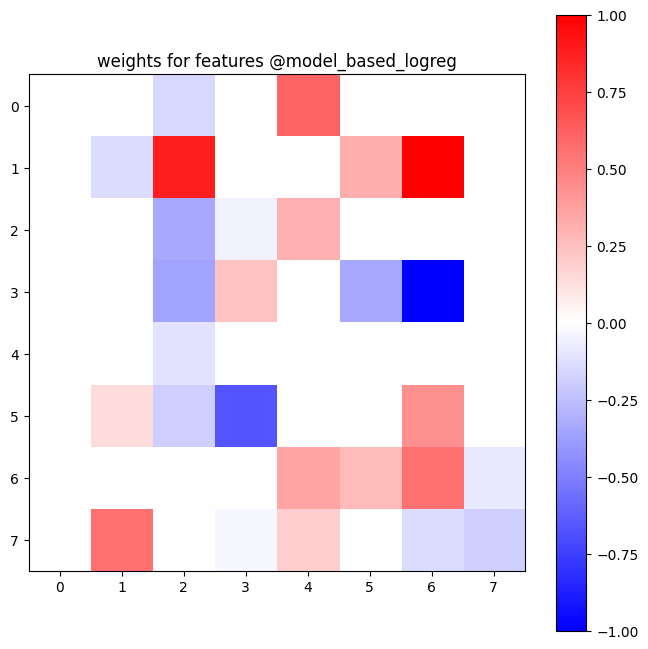

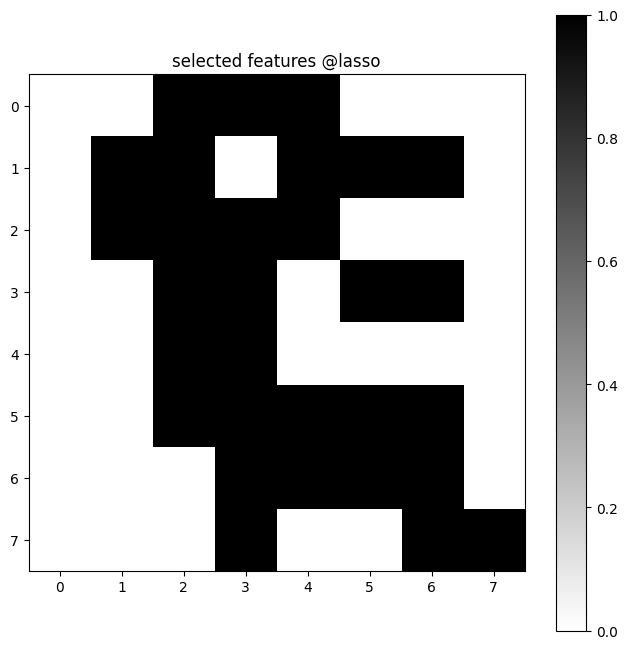

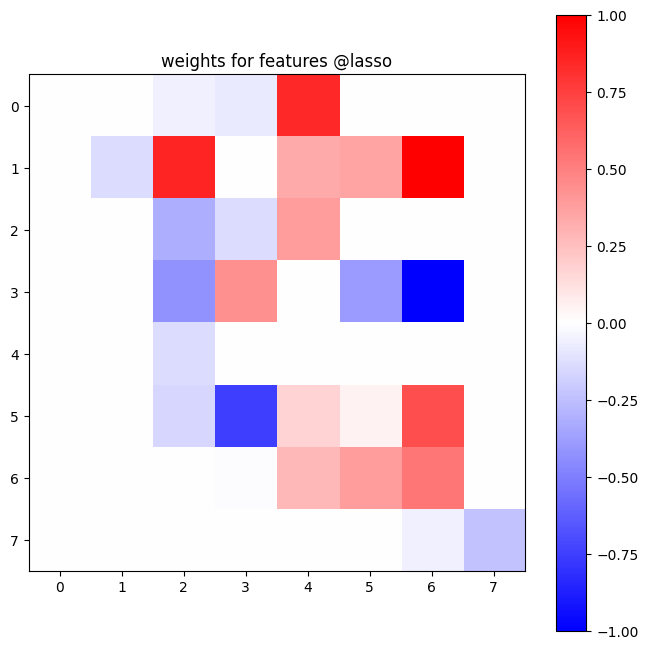

In [63]:
def scale01(s):
        return (s-s.min())/(s.max()-s.min())

for method in methods:
    selected_vars_with_method = summary.loc[method, "features"]
    plt.figure(figsize=(8,8))
    vars64 = np.array([1 if str(item) in selected_vars_with_method else 0 for item in X_train.columns])
    plt.imshow(vars64.reshape(8, 8), cmap='gray_r', vmin=0, vmax=1)
    plt.title(f'selected features @{method}')
    plt.colorbar()
    plt.show()

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train[selected_vars_with_method], y_train)
    all_pixels_weights = pd.DataFrame(index=X_train.columns)
    all_pixels_weights = all_pixels_weights.join(pd.DataFrame(model.coef_[0], index=selected_vars_with_method))
    all_pixels_weights = all_pixels_weights.fillna(0)

    negative_coefs = all_pixels_weights.loc[all_pixels_weights[0]<0]
    scaled_negatives_to_minus1_0 = scale01(negative_coefs)-1
    positive_coefs = all_pixels_weights.loc[all_pixels_weights[0]>0]
    scaled_positives_to_0_1 = scale01(positive_coefs)
    all_pixels_weights['scaled'] = pd.concat([scaled_negatives_to_minus1_0, scaled_positives_to_0_1])
    all_pixels_weights['scaled'] = all_pixels_weights['scaled'].fillna(0)

    all_pixels_weights_array = np.array(all_pixels_weights['scaled'].tolist())
    plt.figure(figsize=(8,8))
    plt.imshow(all_pixels_weights_array.reshape(8, 8), cmap='bwr')
    plt.colorbar()
    plt.title(f'weights for features @{method}')
    plt.show()